In [1]:
#import torch, gc
#gc.collect()
#torch.cuda.empty_cache()
#!pip uninstall -y -r <(pip freeze)

In [2]:
!pip install transformers
!pip install torch
!pip install transformers datasets evaluate
!pip install accelerate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 33.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 35.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 26.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 40.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 13

In [3]:
#!pip install ipywidgets

In [4]:
import torch
import transformers
import datasets
import json
import pandas as pd
import numpy as np
import evaluate
from datasets import Dataset
from transformers import AutoTokenizer
from transformers import BertForSequenceClassification
from transformers import TrainingArguments
from transformers import Trainer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
%cd '/content/drive/MyDrive/hatefulmemes'
#!ls

/content/drive/MyDrive/hatefulmemes


In [7]:
train = pd.read_json("data/train.jsonl",lines=True)
test = pd.read_json("data/test.jsonl",lines=True)
val = pd.read_json("data/dev.jsonl",lines=True)
#captions = pd.read_json("data/Image_Captions_Output.json",lines=True)

In [8]:
train.head()

,id,img,label,text
0,42953,img/42953.png,0,its their character not their color that matters
1,23058,img/23058.png,0,don't be afraid to love again everyone is not ...
2,13894,img/13894.png,0,putting bows on your pet
3,37408,img/37408.png,0,i love everything and everybody! except for sq...
4,82403,img/82403.png,0,"everybody loves chocolate chip cookies, even h..."


In [9]:
#train.dtypes

In [10]:
#with open('data/Image_Captions_Output.json', 'r') as file:
#    captions_data = json.load(file)
with open('data/Image_Captions_Output.json', 'r') as file:
    captions_data = json.load(file)

In [11]:
captions_formatted = {}
for (key,value) in captions_data.items():
  k = int(key.replace('.png',''))
  captions_formatted[k] = value

#print(captions_formatted)

In [12]:
captions = pd.DataFrame([{"id": key, "img_caption": value} for key, value in captions_formatted.items()])


In [13]:
captions.head()

,id,img_caption
0,13726,a man is holding a camera and a bag
1,89764,a man in a suit and tie standing on a beach
2,64720,a woman is cutting a cake with a knife
3,70231,a man in a suit and tie holding a microphone
4,86934,a man in a suit and tie is speaking to a group...


In [14]:
test_captions = test.join(captions.set_index('id'), on='id')

In [15]:
test_captions.head()

,id,img,text,img_caption
0,16395,img/16395.png,handjobs sold seperately,a woman in a black dress with a smile
1,37405,img/37405.png,introducing fidget spinner for women,a man is looking at a mirror in a room
2,94180,img/94180.png,happy pride month let's go beat up lesbians,a woman in a red dress is standing in front of...
3,54321,img/54321.png,laughs in [majority of u.s crime rate],a man and woman are kissing on the lips
4,97015,img/97015.png,finds out those 72 virgins.. are goats,a man with a beard is holding a sign


In [16]:
train_captions = train.merge(captions, on="id")
train_captions = train_captions[["id","img_caption", "text","label"]]
train_captions.index = train_captions["id"]
del train_captions["id"]
train_dataset = Dataset.from_pandas(train_captions)
print(train_dataset)

Dataset({
    features: ['img_caption', 'text', 'label', 'id'],
    num_rows: 8500
})


In [17]:
val_captions = val.merge(captions, on="id")
val_captions = val_captions[["id","img_caption", "text","label"]]
val_captions.index = val_captions["id"]
del val_captions["id"]
#val_ds = val_captions[["img_caption", "text"]]
val_dataset = Dataset.from_pandas(val_captions)
print(val_dataset)

Dataset({
    features: ['img_caption', 'text', 'label', 'id'],
    num_rows: 500
})


In [18]:
#References 

#https://huggingface.co/transformers/v3.3.1/training.html
#https://grabngoinfo.com/transfer-learning-for-text-classification-using-hugging-face-transformers-trainer/

In [19]:
#tokenizer = AutoTokenizer.from_pretrained("bert-large-uncased")
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

def tokenize_function(examples):
    return tokenizer(examples["img_caption"], examples['text'], padding="max_length", truncation=True)

In [20]:
tokenized_train_dataset = train_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/8500 [00:00<?, ? examples/s]

In [21]:
tokenized_val_dataset = val_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

In [22]:
#model = BertForSequenceClassification.from_pretrained("bert-large-uncased")
model = BertForSequenceClassification.from_pretrained("bert-base-cased")

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

In [23]:
def fun_compute_metrics(eval_pred):
    metric = evaluate.load("accuracy")
    logits, labels = eval_pred
    # probabilities = tf.nn.softmax(logits)
    predictions = np.argmax(logits, axis=1)
    return metric.compute(predictions=predictions, references=labels)

In [24]:
training_args = TrainingArguments(
    output_dir='data/results',          # output directory
    num_train_epochs=5,              # total # of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=32,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='data/logs',            # directory for storing logs
)

In [25]:
trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=tokenized_train_dataset,         # training dataset
    eval_dataset=tokenized_val_dataset,            # evaluation dataset
    compute_metrics=fun_compute_metrics
)

In [26]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
500,0.621200
1000,0.538600
1500,0.416600
2000,0.288100
2500,0.174000


TrainOutput(global_step=2660, training_loss=0.39245811046514295, metrics={'train_runtime': 3846.8495, 'train_samples_per_second': 11.048, 'train_steps_per_second': 0.691, 'total_flos': 1.11822198528e+16, 'train_loss': 0.39245811046514295, 'epoch': 5.0})

In [27]:
trainer.evaluate(tokenized_val_dataset)
#import torch
#torch.cuda.empty_cache()

{'eval_loss': 1.7896181344985962,
 'eval_accuracy': 0.616,
 'eval_runtime': 17.6116,
 'eval_samples_per_second': 28.39,
 'eval_steps_per_second': 0.908,
 'epoch': 5.0}

In [28]:
y_test_predict = trainer.predict(tokenized_val_dataset)

In [29]:
import tensorflow as tf
y_test_logits = y_test_predict.predictions
y_test_probabilities = tf.nn.softmax(y_test_logits)
y_test_pred_labels = np.argmax(y_test_probabilities, axis=1)
y_test_actual_labels = y_test_predict.label_ids

In [30]:
# Load f1 metric
metric_f1 = evaluate.load("f1")

# Compute f1 metric
metric_f1.compute(predictions=y_test_pred_labels, references=y_test_actual_labels)

# Load recall metric
metric_recall = evaluate.load("recall")

# Compute recall metric
val_recall = metric_recall.compute(predictions=y_test_pred_labels, references=y_test_actual_labels)

metric_acc = evaluate.load("accuracy")

# Compute accuracy metric
val_accuracy = metric_acc.compute(predictions=y_test_pred_labels, references=y_test_actual_labels)


metric_roc_auc = evaluate.load("roc_auc")

# Compute roc_auc metric
val_roc_auc = metric_roc_auc.compute(prediction_scores=y_test_pred_labels, references=y_test_actual_labels)

In [31]:
print(val_accuracy)
print(val_recall)
print(val_roc_auc)

{'accuracy': 0.616}
{'recall': 0.42}
{'roc_auc': 0.616}


In [32]:
Val_df = val_captions
Val_df["id"] = Val_df.index
Val_df["pred"] = y_test_pred_labels

In [33]:
Val_df.to_csv('data/Test_Predictions.csv') 

In [34]:
import pandas as pd

df = pd.read_csv('data/Test_Predictions.csv')
df.head()

,id,img_caption,text,label,id.1,pred
0,8291,a woman sitting on a curb eating a piece of food,white people is this a shooting range,1,8291,0
1,46971,a man holding a sign with a picture of a woman,bravery at its finest,1,46971,0
2,3745,a woman is sitting at a desk with a laptop,your order comes to $37.50 and your white priv...,1,3745,0
3,83745,a man wearing a costume holding a large piece ...,it is time.. to send these parasites back to t...,1,83745,1
4,80243,a crowd of people standing around a group of p...,mississippi wind chime,1,80243,1


In [35]:
actual = df["label"]
predicted = df["pred"]
from sklearn import metrics
confusion_matrix = metrics.confusion_matrix(actual, predicted)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

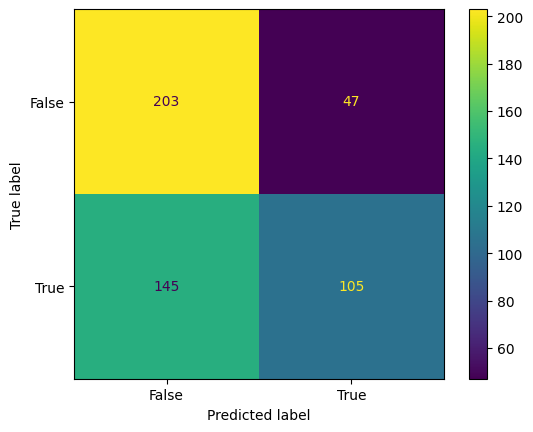

In [36]:
import matplotlib.pyplot as plt
cm_display.plot()
plt.show()